<a href="https://colab.research.google.com/github/shaoncsecu/BN-HTR/blob/main/HWR_LineSegment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/BanglaHWR/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/BanglaHWR


In [2]:
#pip install scikit-plot

In [3]:
import cv2
import numpy as np
import os                  # dealing with directories
from tqdm import tqdm      # a nice pretty percentage bar for tasks.
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt
import imutils
from collections import namedtuple
%matplotlib inline

In [4]:
INPUT_DIR = 'Testing'
OUTPUT_DIR = 'Output'

In [5]:
def read_input_images():
    '''This function reads the input images from the INPUT_DIR 
    *** Needs work for BATCH processing (future) of huge numbers of inputs'''
    # For all images in INPUT_DIR
    image_data = []
    # For all images path(area)
    image_paths = []
    for img in tqdm(os.listdir(INPUT_DIR)):
        path = os.path.join(INPUT_DIR,img)
        print(path.split())
        # Append all image paths(name) in a list(for crop_image function)
        image_paths.append(path.split('/')[1].split('.')[0])
        # We can either read the grayscale image directly using - cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.imread(path)
        # Resizing the image mainitainig the aspect ratio
        img = imutils.resize(img, width=1000)
        # Append all images in an array
        image_data.append(np.array(img))
        
    print(image_paths)
    return image_data, image_paths

In [6]:
def pre_processing(thresh, plot_image = True):
  # noise removal
  kernel = np.ones((2,2),np.uint8)
  opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
  
  # sure background area
  sure_bg = cv2.dilate(opening,kernel,iterations=6)

  # Finding sure foreground area
  dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
  ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
  
  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)
  
  if plot_image:
    print("\tForeground detection")
    plot_fig(sure_fg)
    print("\tBackground subtraction")
    plot_fig(unknown)
  return unknown

In [7]:
def Thresholded_Edge(im, plot_image = True):
  '''This function binarizes a Grayscale Image and produces Edges of that image'''
  # Convert an image from one color space to another
  im_gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
  # Applying the thresholding
  ret,thresh = cv2.threshold(im_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # To detect edges in an image
  edges = cv2.Canny(im_gray,50,150,apertureSize = 3)
  
  if plot_image:
    print("\tThresholded image")
    plot_fig(thresh)
    print("\tCanny edge detection")
    plot_fig(edges)

  return thresh, edges

In [8]:
def Hough_LineDetection(thresh, edges, plot_image = True):
    # Hough Line Transformation - To thicken the lines/মাত্রা (একই শব্দকে এক সাথে করার জন্য)
    '''
    minLineLength - Minimum length of line. Line segments shorter than this are rejected.
    maxLineGap - Maximum allowed gap between line segments to treat them as single line.
    '''
    minLineLength = 1
    maxLineGap = 10
    
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength, maxLineGap)

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(thresh,(x1,y1),(x2,y2),(255), 2)
    
    if plot_image:
      print("\tHough Line Detection")
      plot_fig(thresh)

In [9]:
def hough_circle_removal(thresh, edges, plot_image = True):
    '''This function will remove the circle like shapes... ই-কার(ি)/এ-কার(ে)'''
    # Obtain Hough Circles
    circles = cv2.HoughCircles(edges,cv2.HOUGH_GRADIENT,60,70,
                                param1=50,param2=30,minRadius=60,maxRadius=70)
    # Convert circles to unit16
    circles = np.uint16(np.around(circles))
    # Loop though the Circles and draw them
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(thresh,(i[0],i[1]),i[2],(0),2)
        # draw the center of the circle
        cv2.circle(thresh,(i[0],i[1]),2,(0),2)

    if plot_image:
      print("\tHough circle removal")
      plot_fig(thresh)

In [10]:
def Bounding_Box(im, thresh, draw_box = True, plot_image = True):
    '''This function generates the bounding boxes over possbile words
    and provides the mid points of those bounding boxes'''

    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    minArea = 200 # min area for to be considered

    Y_points = []
    cords = []
    top_cords = []
    bottom_cords = []
    top_cords0 = []
    top_cords1 = []
    bottom_cords0 = []
    bottom_cords1 = []
    midpoint_list = []
    heights = []
    for cnt in contours:
        area=cv2.contourArea(cnt)
        if(area>minArea):
            rect = cv2.minAreaRect(cnt)
            x_topL, y_topL, w, h = cv2.boundingRect(cnt)

            # Calculate the average height
            heights.append(h)
            avg_height = sum(heights) // len(heights) 
           
            if h<100:
                box = cv2.boxPoints(rect)
                box = np.int0(box)
                
                # For the middle point of a box
                x0, y0 = box[1]
                x1, y1 = box[3]
                x = (x0+x1)//2
                y = (y0+y1)//2
                cords.append((x,y))

                # For the Top points of all boxes
                top_x0, top_y0 = box[0]
                top_x1, top_y1 = box[1]
                top_cords0.append((top_x0,top_y0))
                top_cords1.append((top_x1,top_y1))
                top_cords = top_cords0 + top_cords1
            
                # For the Bottom points of all boxes
                bottom_x0, bottom_y0 = box[2]
                bottom_x1, bottom_y1 = box[3]
                bottom_cords0.append((bottom_x0,bottom_y0))
                bottom_cords1.append((bottom_x1,bottom_y1))
                bottom_cords = bottom_cords0 + bottom_cords1

                Y_points.append([y])

                if draw_box:
                    cv2.drawContours(im,[box],0,(0,0,255),3)
                    # Draw the middle points
                    im = cv2.circle(im, (x,y), radius=1, color=(0, 0, 255), thickness=3)
    
    if plot_image:
      plot_fig(im)
    return im, cords, Y_points, top_cords, bottom_cords

In [11]:
def find_negative_clusters(labels, cords):
    '''This function finds the co-ordinates of the -1 cluster and stores them in an array of array of tuples'''

    neg_clus = []
    temp = []
    flag = True

    for lbl, cord in zip(labels, cords):
        if lbl == -1:
            if flag:
                temp = []
                flag = False
            temp.append(cord)
        
        elif not flag:
            neg_clus.append(temp)
            flag = True

    if not flag:
        neg_clus.append(temp)

    return neg_clus

In [12]:
def orderd_lines(lines, cords_sorted):

    # creating a dictionary with the 'cluster labels' as 'keys' abd empty [] as values
    line_dic = {line: [] for line in lines}
    sorted_lines = {line: [] for line in lines}

    # this won't work if different line annotates with same label (in that case we have to use find_negative_clusters() like function)
    for line, cord in zip(lines, cords_sorted):
        if line != -1:
            temp = line_dic[line]
            temp.append(cord)
            line_dic[line] = temp
    
    print("Regular Line = ", line_dic)

    # populate all the co-ordinates (groups) for the cluster label = -1 (usually miss-clusters)
    if -1 in sorted_lines:
        neg_lines = find_negative_clusters(lines, cords_sorted)
        del(line_dic[-1])
        del(sorted_lines[-1])

        # Adding the -1 clusters when they are more than 3 points
        line_len = len(line_dic)
        for neg_line in neg_lines:
            if len(neg_line)>3:
                line_len += 1
                line_dic[line_len] = neg_line


    for line in line_dic:
        # sorting the co-ordinates inside the array w.r.t X axis (words)
        sorted_lines[line] = sorted(line_dic[line], key=lambda x: x[0])
    
    print("Sorted Lines = ", sorted_lines)

    return sorted_lines

In [13]:
def OPTICS_clustering(cords, top_cords, bottom_cords,Y_points):
    # We are using optics clustering
    clust = OPTICS(min_samples=5, max_eps=20, metric='minkowski').fit(Y_points)
    lines = clust.labels_

    # Co-ordinates are sorted according to the cluster labels
    cords_sorted = [cords[indx] for indx in clust.ordering_]
    cords_sorted1 = [top_cords[indx] for indx in clust.ordering_]
    cords_sorted2 = [bottom_cords[indx] for indx in clust.ordering_]
    # A dictionary with 'key' as 'line/cluster label' and values as a sorted list according to X-axis (look for line -1 if any!!)
    sorted_lines = orderd_lines(lines, cords_sorted)
    sorted_lines1 = orderd_lines(lines, cords_sorted1)
    sorted_lines2 = orderd_lines(lines, cords_sorted2)

    return sorted_lines, sorted_lines1, sorted_lines2

In [14]:
def get_non_neg_lines(sorted_lines):
    '''This function will check if we have -1 clusters in the lines and for now start from non-negative lines'''
    
    # TO-DO: line_no[0] will be -1 so ignore it for now...
    start_indx = 0
    if -1 in sorted_lines.keys():
        start_indx = 1
        
    line_no = list(sorted_lines.keys())[start_indx:]

    return line_no

In [15]:
def annotate_line_number(im, sorted_lines, plot_image = True):
    '''This function puts line number as a Text in the Bounding Boxes'''
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    line_no = get_non_neg_lines(sorted_lines)
    
    for line in line_no:
        for point in sorted_lines[line]:
            cv2.putText(im, str(line), point, font, 1, (255,0,0), 2)
    
    if plot_image:
      print("Line number according to cluster")
      plot_fig(im)

In [16]:
def draw_lines(im, sorted_lines, sorted_lines1, sorted_lines2, draw_line = True, plot_image = False):
    '''This function draws lines from a dictionary {line_no: [(x1,y1), (x2,y2),...]}'''
        
    line_no = get_non_neg_lines(sorted_lines)
    max_points = []
    min_points = []
    for line in line_no:
        points = np.array(sorted_lines[line], np.int32)

        if draw_line:
          cv2.polylines(im, [points], isClosed = False, color = (255, 0, 255), thickness = 2)
    # Finding the maximum points for the each lines from the Top points
    for line in sorted_lines1:
      max_point = tuple(max(sorted_lines1[line], key = lambda x:x[1]))
      #cv2.circle(im, (max_point), radius=1, color=(0, 255, 0), thickness=5)
      #print("Max for Line = ", line)
      #print(max_point)
      #if draw_line:
        #cv2.circle(im, (max_point), radius=1, color=(0, 255, 0), thickness=5)
        #cv2.line(im, (0, max_point[1]),(im.shape[1] , max_point[1]) ,(0, 255, 0), 2)
      max_points.append(max_point[1])

    # Finding the minimum points for the each lines from the Top points
    for line in sorted_lines2:
      min_point = tuple(min(sorted_lines2[line], key = lambda x:x[1]))
      #cv2.circle(im, (min_point), radius=1, color=(0, 255, 0), thickness=5)
      #print("Min for Line = ", line)
      #print(min_point)
      #if draw_line:
        #cv2.circle(im, (min_point), radius=1, color=(0, 255, 0), thickness=5)
        #cv2.line(im, (0, min_point[1]),(im.shape[1] , min_point[1]) ,(0, 255, 0), 2)
      min_points.append(min_point[1])
    if plot_image:
      print("Adding the midpoints")
      plot_fig(im)
    return max_points,min_points, line_no

In [17]:
from google.colab.patches import cv2_imshow

def plot_cv2(img):
    cv2_imshow(cv2.cvtColor(im,cv2.COLOR_GRAY2RGB))

In [18]:
def plot_fig(img):
  #print("Image: W = {}\t H = {}".format(img.shape[1],img.shape[0]))
  plt.figure(figsize=(15,15))
  # plt.imshow(img, cmap='gray')
  plt.imshow(imutils.opencv2matplotlib(img))
  #plt.imshow(imutils.opencv2matplotlib(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
  plt.show()

In [19]:
def MaxMin_dic(im, line_no, max_points, min_points):
  '''This function is used for Adding the maximum and miimum Y values in a dictionary'''
  maxmin_dic = {line: [] for line in line_no}
  merged_list = [(max_points[i], min_points[i]) for i in range(0, len(max_points))] 
  for line,cord in zip(line_no, merged_list):
      temp = maxmin_dic[line]
      temp.append(cord)
      maxmin_dic[line] = temp
  print("Maximum and Minimum points for each line(max_point, min_point)")
  print(maxmin_dic)
  return maxmin_dic

In [20]:
def crop_image(im, maxmin_dic, image_name, crop = True, rect = True):
  '''This function is used for cropping each lines from an image'''
  for key in maxmin_dic:
    max_y, min_y = maxmin_dic[key][0]
    # Getting ROI
    # Add a padding for cropping
    pad = 10
    if (min_y-pad)<0:
      min_y = 0
    elif (max_y+pad)>im.shape[0]:
      max_y = im.shape[0]
    roi = im[min_y:max_y, :]
    # show ROI
    #cv2.imshow('line no:'+str(i),roi)
    # Saving the image
    folder_name = image_name
    if not os.path.exists(folder_name):
      os.mkdir(folder_name)

    filename = str(key)+'.jpg'
    if crop:
      cv2.imwrite(os.path.join(folder_name, filename), roi)
    if rect:
      # drawing the ractangle over the image
      cv2.rectangle(im,(0, min_y), (im.shape[1], max_y),(90,0,255),2)
      plot_fig(im)
    #cv2.waitKey(0)
    #cv2.imshow('marked areas',im)
  return min_y, max_y

In [21]:
# Working on it
def rectangle_overlap(im, min_y, max_y, maxmin_dic):
  x = 0
  y = 1
  # Driver's Code
  l1 = [0, min_y]
  r1 = [im.shape[1], max_y]
  l2 = [0, min_y]
  r2 = [im.shape[1], max_y]
  
  ''' Length of intersecting part i.e start from max(l1[x], l2[x]) of  x-coordinate and end at min(r1[x], 
      r2[x]) x-coordinate by subtracting start from end we get required lengths '''
  x_dist = (min(r1[x], r2[x]) - max(l1[x], l2[x]))
  y_dist = (min(r1[y], r2[y]) - max(l1[y], l2[y]))
  areaI = 0
  if x_dist > 0 and y_dist > 0:
    areaI = x_dist * y_dist
  area = area1 + area2 - areaI
 
  print(x_dist)
  print(y_dist)
  return (area)

 40%|████      | 2/5 [00:00<00:00, 11.96it/s]

['Testing/95_4.png']
['Testing/57_3.jpg']
['Testing/80_4.jpg']


 80%|████████  | 4/5 [00:00<00:00,  8.87it/s]

['Testing/79_5.jpg']
['Testing/42_2.jpg']


100%|██████████| 5/5 [00:00<00:00,  8.40it/s]


['95_4', '57_3', '80_4', '79_5', '42_2']
Main image
42_2


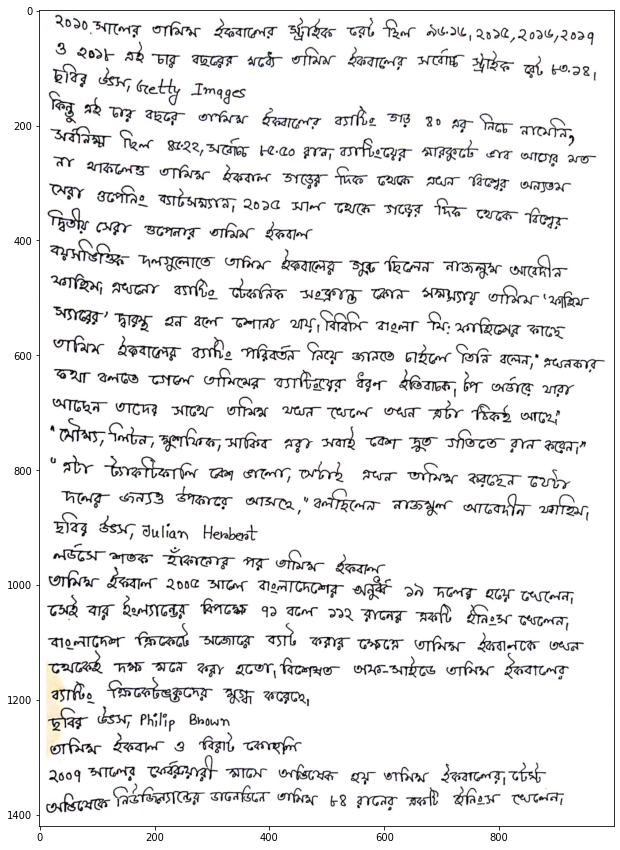

	Thresholded image


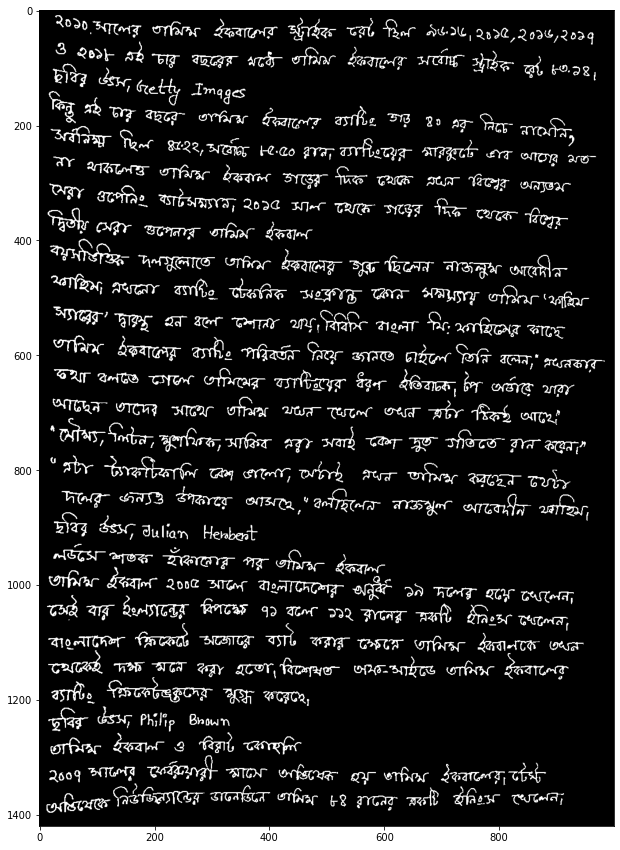

	Canny edge detection


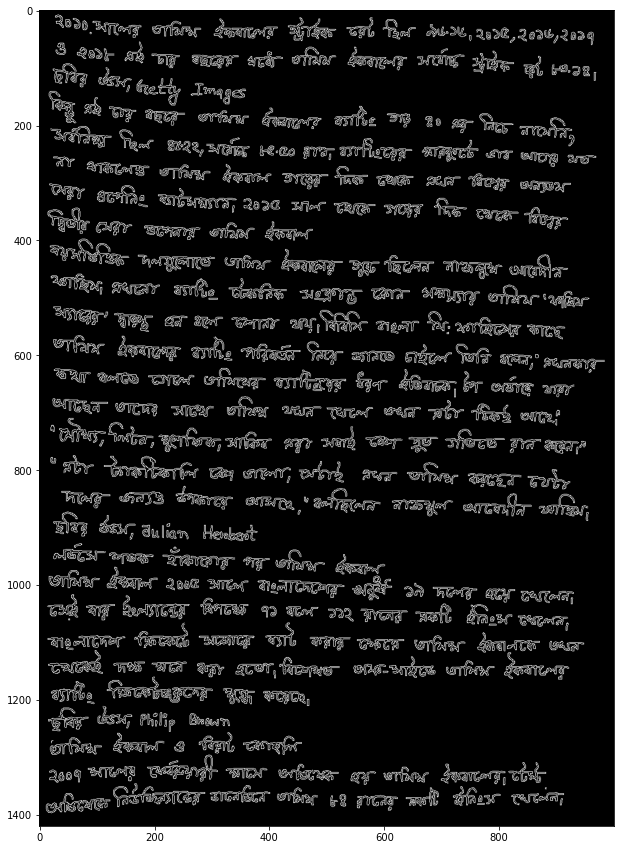

Regular Line =  {0: [(149, 1384), (70, 1389), (734, 1379), (597, 1380), (667, 1379), (475, 1378), (268, 1377), (447, 1375), (184, 1375), (887, 1373), (839, 1372), (358, 1372), (322, 1372), (227, 1375)], 1: [(561, 1342), (710, 1339), (732, 1338), (649, 1339), (74, 1339), (42, 1336), (435, 1332)], -1: [], 2: [(201, 1286), (425, 1289), (170, 1287), (64, 1289), (324, 1286), (387, 1283)], 3: [(304, 1243), (69, 1246), (41, 1247), (226, 1245), (141, 1238), (201, 1238)], 4: [(465, 1205), (433, 1201), (407, 1198), (60, 1196), (339, 1193), (291, 1195), (207, 1192), (247, 1194), (154, 1192)], 5: [(854, 1154), (752, 1153), (649, 1153), (909, 1152), (575, 1152), (477, 1153), (303, 1152), (369, 1150), (43, 1149), (231, 1146), (89, 1146), (161, 1147)], 6: [(938, 1110), (906, 1110), (773, 1110), (863, 1109), (700, 1111), (596, 1108)], 7: [(515, 1104), (33, 1103), (356, 1104), (98, 1103), (207, 1101), (426, 1100), (250, 1099), (304, 1098)], 8: [(468, 1053), (201, 1049), (171, 1051), (38, 1049), (239, 1

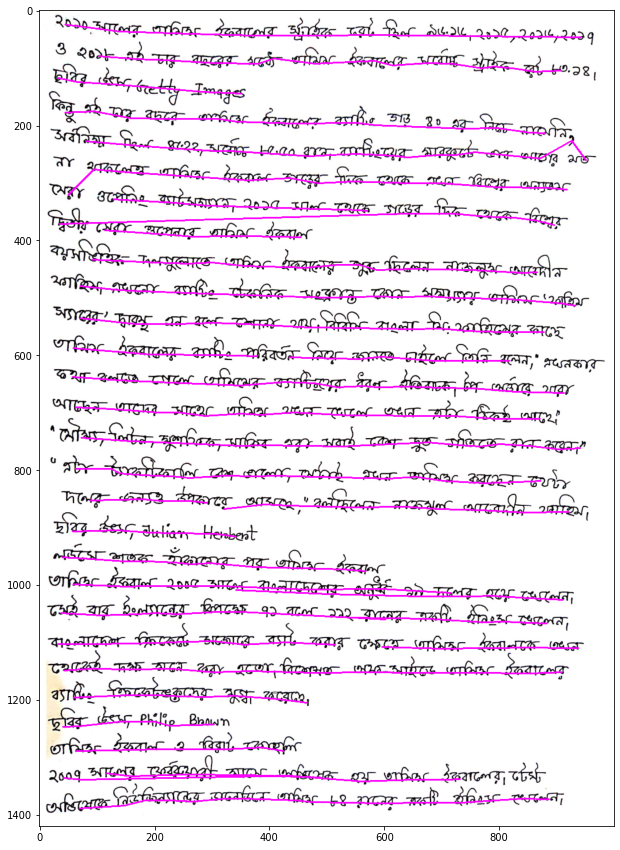

Maximum and Minimum points for each line(max_point, min_point)
{0: [(1409, 1360)], 1: [(1355, 1322)], 2: [(1306, 1272)], 3: [(1262, 1226)], 4: [(1218, 1179)], 5: [(1166, 1134)], 6: [(1123, 1096)], 7: [(1120, 1086)], 8: [(1074, 1033)], 9: [(1038, 1002)], 10: [(1027, 985)], 11: [(987, 941)], 12: [(925, 891)], 13: [(887, 846)], 14: [(869, 838)], 15: [(837, 787)], 16: [(778, 730)], 17: [(725, 677)], 18: [(680, 621)], 19: [(623, 585)], 20: [(572, 516)], 21: [(524, 459)], 22: [(467, 409)], 23: [(408, 372)], 24: [(360, 318)], 25: [(340, 267)], 26: [(274, 208)], 27: [(224, 156)], 28: [(118, 65)], 29: [(60, 16)], 31: [(1348, 1315)], 32: [(1078, 1049)], 33: [(620, 574)], 34: [(398, 341)], 35: [(155, 104)]}


In [30]:
""" *** RUN THIS CHUNK OF CODE *** """
# index is the index from the input images that you want to test
index = 4

image_data, image_paths = read_input_images()

im = image_data[index]
print("Main image")
print(image_paths[index])
plot_fig(im)
thresh, edges = Thresholded_Edge(im, plot_image = True)

Hough_LineDetection(thresh, edges, plot_image = False)
hough_circle_removal(thresh, edges, plot_image = False)

thresh = pre_processing(thresh, plot_image = False)
#thresh = Dilation_image(thresh, plot_image = True)

im, cords, Y_points, top_cords, bottom_cords = Bounding_Box(im, thresh, draw_box = False, plot_image = False)
sorted_lines, sorted_lines1, sorted_lines2 = OPTICS_clustering(cords, top_cords, bottom_cords, Y_points)
#annotate_line_number(im, sorted_lines, plot_image = True)
max_points, min_points, line_no = draw_lines(im, sorted_lines, sorted_lines1, sorted_lines2, draw_line = True, plot_image = True)
maxmin_dic = MaxMin_dic(im, line_no, max_points, min_points)
min_y,max_y = crop_image(im, maxmin_dic, image_paths[index], crop = True, rect = False)
#area = rectangle_overlap(im, min_y, max_y)